# Menyediakan Feature dan Label

Mengimpor library dan Memeriksa versi tensorflow

In [ ]:
#Mengimpor library tensorflow
import tensorflow as tf

#Mengimpor library NumPy
import numpy as np

#Mengimpor library matplotlib
import matplotlib.pyplot as plt

#Memeriksa versi tensorflow
print(tf.__version__)

2.5.0


Membuat dataset sederhana dengan tf.data.Dataset

In [ ]:
#Membuat dataset dengan nilai sebanyak 10
dataset = tf.data.Dataset.range(10)  
for nilai in dataset:
   print(nilai.numpy())

0
1
2
3
4
5
6
7
8
9


Menambahkan dataset.window pada dataset sebelumnya

In [ ]:
#Menambahkan dataset.window untuk membuat windowed dataset
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1) 
for window_dataset in dataset:
  for nilai in window_dataset:
    print(nilai.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


Menambahkan drop_remainder

In [ ]:
dataset = tf.data.Dataset.range(10)
#Menambahkan drop remainder
dataset = dataset.window(5, shift=1, 
                         drop_remainder=True)
for window_dataset in dataset:
  for nilai in window_dataset:
    print(nilai.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


Memasukkan nilai ke daftar numpy

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, 
                         drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for nilai in dataset:
  print(nilai.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


Membagi data menjadi feature dan label

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))

#Membagi data dengan pemetaan
dataset = dataset.map(lambda window: 
                      (window[:-1], window[-1:]))
for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


Menambahkan metode shuffle

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: 
                      (window[:-1], window[-1:]))
#Mengacak Data
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(), y.numpy())

[3 4 5 6] [7]
[2 3 4 5] [6]
[4 5 6 7] [8]
[1 2 3 4] [5]
[5 6 7 8] [9]
[0 1 2 3] [4]


# Menyiapkan Windowed Dataset

In [ ]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer
                            ).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

# Time Series Forecasting dengan Single Layer Neural Network

Mengimpor library dan Memeriksa versi tensorflow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


Membuat fungsi data series

In [ ]:
#Fungsi untuk membuat visualisasi grafik time series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Waktu") #Sumbu x
    plt.ylabel("Nilai") #Sumbu y
    plt.grid(True) #menampilkan grid

#Fungsi untuk membuat pola trend
#Nilainya boleh diubah diatur sesuai keinginan
def trend(time, slope=0):
    return slope * time

#Fungsi untuk membuat pola seasonal
#Nilainya boleh diubah diatur sesuai keinginan
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

#Fungsi untuk membuat pola seasonality
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

#Fungsi untuk membuat pola noise
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

#Mengatur nilai time (waktu)
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10 #Mengatur nilai baseline
series = trend(time, 0.1)   #Mengatur seriesnya
baseline = 10
amplitude = 40 #Mengatur amplitude
slope = 0.05  #Mengatur slope
noise_level = 5  #Mengatur level noise

#Membuat Seriesnya
series = baseline + trend(time, slope) + seasonality(time, 
                                                     period=365, 
                                                     amplitude=amplitude)
#Diperbarui dengan menambahkan noise
series += noise(time, noise_level, seed=42)

Membagi Dataset

In [ ]:
split_time = 1000 #Membagi time menjadi 1000
time_train = time[:split_time] #data time untuk training
x_train = series[:split_time] #data series untuk training
time_valid = time[split_time:] #data time untuk validasi
x_valid = series[split_time:] #data series untuk validasi

window_size = 20 #mengatur ukuran window
batch_size = 32 #mengatur ukuran batch
shuffle_buffer_size = 1000 #mengatur ukuran buffer acak

Menambahkan Fungsi Windowed Dataset

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, 
                           drop_remainder=True)
  dataset = dataset.flat_map(lambda window: 
                             window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: 
                                                (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Membuat Model

In [ ]:
#Memanggil Fungsi Windowed Dataset
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, 
                           shuffle_buffer_size)
print(dataset)

#Membuat Dense Layer
layer = tf.keras.layers.Dense(1, input_shape=[window_size])

#Membuat single layer neural network
model = tf.keras.models.Sequential([layer]) 

#Membuat simpulan model
model.summary()

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


Hasil Prediksi

In [ ]:
#Mengcompile model
model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, 
                                                momentum=0.9))
#Mentraining Model
model.fit(dataset,epochs=100,verbose=0)

#Menampilkan Hasil Prediksi
print("Layer weights {}".format(layer.get_weights()))

Layer weights [array([[ 0.00443255],
       [ 0.01571949],
       [-0.07040853],
       [ 0.03775336],
       [ 0.05365657],
       [-0.03994824],
       [-0.05268764],
       [ 0.01512054],
       [ 0.09043963],
       [-0.02449548],
       [-0.01068988],
       [-0.01742059],
       [-0.03740674],
       [ 0.03737618],
       [ 0.01240223],
       [ 0.05499949],
       [ 0.06272443],
       [ 0.19534782],
       [ 0.24700455],
       [ 0.42925066]], dtype=float32), array([0.01590855], dtype=float32)]


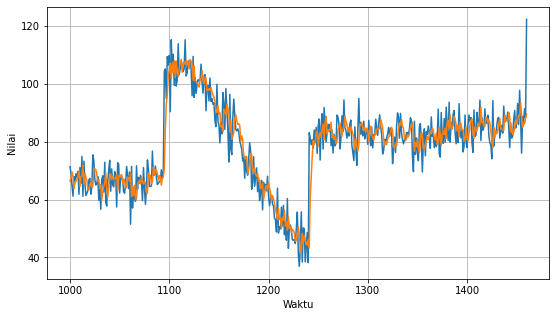

In [ ]:
#Membuat Prediksi
prediksi = []

for time in range(len(series) - window_size):
  prediksi.append(model.predict(series[time:time + window_size]
                                [np.newaxis]))

prediksi = prediksi[split_time-window_size:]
Hasil = np.array(prediksi)[:, 0, 0]

#Mengatur ukuran grafik
plt.figure(figsize=(9, 5))

plot_series(time_valid, x_valid) #Visualisasi data aktual
plot_series(time_valid, Hasil) #Visualisasi prediksi

Mengukur Hasil Mean Absolute Error

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, Hasil).numpy()

4.921086